In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import moscot
from anndata import AnnData
import numpy as np
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver, LRSinkhornSolver
from moscot.solvers._data import TaggedArray, Tag
import matplotlib.pyplot as plt
import jax.numpy as jnp
from typing import *
import pandas as pd
import networkx as nx
import jax.numpy as jnp
from moscot.problems.time._lineage import TemporalProblem
import os
import wot
from ott.geometry import pointcloud

In [3]:
import scanpy as sc
import matplotlib as mpl

In [4]:
import ott
import ot
from tqdm import tqdm

In [5]:
data_path = "/home/icb/dominik.klein/data/wot"


VAR_GENE_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
SERUM_CELL_IDS_PATH = os.path.join(data_path, 'serum_cell_ids.txt')
CELL_GROWTH_PATH = os.path.join(data_path, 'growth_gs_init.txt')
FULL_DS_PATH = os.path.join(data_path, 'ExprMatrix.h5ad')
CELL_DAYS_PATH = os.path.join(data_path, 'cell_days.txt')
VAR_DS_PATH = os.path.join(data_path, 'ExprMatrix.var.genes.h5ad')
TMAP_PATH = os.path.join(data_path, 'serum')
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
COORDS_PATH = os.path.join(data_path, 'fle_coords.txt')

In [6]:
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

In [7]:
adata

AnnData object with n_obs × n_vars = 175472 × 1479
    obs: 'day', 'cell_growth_rate'

In [8]:
sc.tl.pca(adata)

In [9]:
CELL_SETS_PATH = os.path.join(data_path, 'major_cell_sets.gmt')
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
cell_to_type = {v[i]: k for k, v in cell_sets.items() for i in range(len(v))}
df_cell_type = pd.DataFrame(cell_to_type.items(), columns=["0", "cell_type"]).set_index("0")
adata.obs = pd.merge(adata.obs, df_cell_type, how="left", left_index=True, right_index=True)

In [10]:
days = list(adata.obs.day.unique())
days.pop(-1) # remove nan

nan

In [12]:
pc_cost_matrix = pointcloud.PointCloud(adata[adata.obs.day==days[0]].obsm["X_pca"], adata[adata.obs.day==days[1]].obsm["X_pca"]).cost_matrix

In [13]:
ot_cost_matrix = ot.dist(adata[adata.obs.day==days[0]].obsm["X_pca"], adata[adata.obs.day==days[1]].obsm["X_pca"])

In [29]:
xs = {}
for i in tqdm(range(len(days)-1)):
    c = ot.dist(adata[adata.obs.day==days[i]].obsm["X_pca"], adata[adata.obs.day==days[i+1]].obsm["X_pca"])
    #c /= np.median(np.array(c))
    adata.uns["cost_matrix_{}".format(i)] = c
    xs[(days[i], days[i+1])] = {"attr": "uns", "key": "cost_matrix_{}".format(i), "tag": Tag.COST_MATRIX}

100%|██████████| 38/38 [00:03<00:00, 10.43it/s]


## Run WOT

In [17]:
#ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

In [18]:
#tmap_annotated = ot_model.compute_transport_map(11,11.5)

## Run Moscot

In [47]:
tp = TemporalProblem(adata, solver=SinkhornSolver(jit=False))

In [48]:
adata.obs.day = adata.obs.day.astype('category')

In [49]:
tp.prepare("day", x=xs, a_marg={"attr": "obs", "key":"cell_growth_rate"})

hi {'attr': 'uns', 'key': 'cost_matrix_0', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_1', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_2', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_3', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_4', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_5', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_6', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_7', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_8', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_9', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_10', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_11', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_12', 'tag': <Tag.COST_MATRIX: 1>}
hi {'attr': 'uns', 'key': 'cost_matrix_13', 'tag': <Tag.COST_

In [22]:
lambda_1 = 1.0
#lambda_2 = 50.0
eps = 5.0
tp.solve(eps=eps, tau_a=lambda_1/(lambda_1+eps), tau_b=1)

## Pull back mass

In [23]:
adata[adata.obs.day==18.0].obs.cell_type.value_counts(dropna=False)

Stromal        1239
Neural          819
NaN             534
Epithelial      503
IPS             412
Trophoblast     292
Name: cell_type, dtype: int64

In [24]:
adata[adata.obs.day==18.0]

View of AnnData object with n_obs × n_vars = 3799 × 1479
    obs: 'day', 'cell_growth_rate', 'cell_type'
    uns: 'pca', 'cost_matrix_0', 'cost_matrix_1', 'cost_matrix_2', 'cost_matrix_3', 'cost_matrix_4', 'cost_matrix_5', 'cost_matrix_6', 'cost_matrix_7', 'cost_matrix_8', 'cost_matrix_9', 'cost_matrix_10', 'cost_matrix_11', 'cost_matrix_12', 'cost_matrix_13', 'cost_matrix_14', 'cost_matrix_15', 'cost_matrix_16', 'cost_matrix_17', 'cost_matrix_18', 'cost_matrix_19', 'cost_matrix_20', 'cost_matrix_21', 'cost_matrix_22', 'cost_matrix_23', 'cost_matrix_24', 'cost_matrix_25', 'cost_matrix_26', 'cost_matrix_27', 'cost_matrix_28', 'cost_matrix_29', 'cost_matrix_30', 'cost_matrix_31', 'cost_matrix_32', 'cost_matrix_33', 'cost_matrix_34', 'cost_matrix_35', 'cost_matrix_36', 'cost_matrix_37'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
#for i in range(38):
#    print(adata.uns[f"cost_matrix_{i}"].shape)

In [26]:
result = tp.pull_back_composed(start=0, end=18, key_groups="cell_type", groups=["IPS"], return_all=True)

3799 3799
(3799, 1) 1.0 (array([0.        , 0.00242718]), array([3387,  412]))
3799 3799
(4068, 1) 0.00026322715
4068 4068
(3678, 1) 0.00024582105
3678 3678
(4645, 1) 0.00027188685
4645 4645
(3422, 1) 0.00021528521
3422 3422
(4851, 1) 0.00029222656
4851 4851
(3717, 1) 0.000206143
3717 3717
(2723, 1) 0.00026903395
2723 2723
(3758, 1) 0.0003672419
3758 3758
(2034, 1) 0.000266099
2034 2034
(2145, 1) 0.0004916419
2145 2145
(2253, 1) 0.00046620044
2253 2253
(2429, 1) 0.00044385245
2429 2429
(2164, 1) 0.0004116916
2164 2164
(2238, 1) 0.0004621072
2238 2238
(1941, 1) 0.00044682756
1941 1941
(2051, 1) 0.0005151982
2051 2051
(2266, 1) 0.00048756698
2266 2266
(2982, 1) 0.00044130615
2982 2982
(3088, 1) 0.0003353451
3088 3088
(3573, 1) 0.000323834
3573 3573
(3829, 1) 0.00027987672
3829 3829
(3815, 1) 0.0002611648
3815 3815
(5061, 1) 0.00026212324
5061 5061
(6507, 1) 0.00019758925
6507 6507
(3111, 1) 0.00015368062
3111 3111
(8422, 1) 0.00032143976
8422 8422
(6550, 1) 0.00011873655
6550 6550
(7227,

In [27]:
r_scaled = []
for r in result:
    r_min = r.min()
    r_max = r.max()
    r_scaled.append((r - r_min)/(r_max - r_min))

In [28]:
result = r_scaled

## Compare

In [29]:
COORD_DF = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)

In [30]:
nbins = 500
xrange = COORD_DF['x'].min(), COORD_DF['x'].max()
yrange = COORD_DF['y'].min(), COORD_DF['y'].max()
COORD_DF['x'] = np.floor(
    np.interp(COORD_DF['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
COORD_DF['y'] = np.floor(
    np.interp(COORD_DF['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)

In [31]:
bdata = adata.copy()
bdata.obs = bdata.obs.join(COORD_DF)

In [32]:
alpha_bins = [0.95, 0.9, 0.5]
def bin_alpha(x):
    if x >= 0.95:
        return 1
    elif x >= 0.9:
        return 0.5
    return 0
days_reverse = days[::-1]
bdata.obs["alpha_bin"] = np.nan
for i in tqdm(range(len(result))):
    assert len(bdata[bdata.obs.day==days_reverse[i]]) == len(result[i]), print(len(bdata[bdata.obs.day==days_reverse[i]]), len(result[i]))
    bdata.obs.loc[bdata.obs.day==days_reverse[i], "alpha_bin"] = list(map(bin_alpha, list(result[i])))

100%|██████████| 39/39 [02:33<00:00,  3.93s/it]


In [33]:
bdata.obs.alpha_bin.value_counts()

0.0    159063
0.5      5359
1.0      1470
Name: alpha_bin, dtype: int64

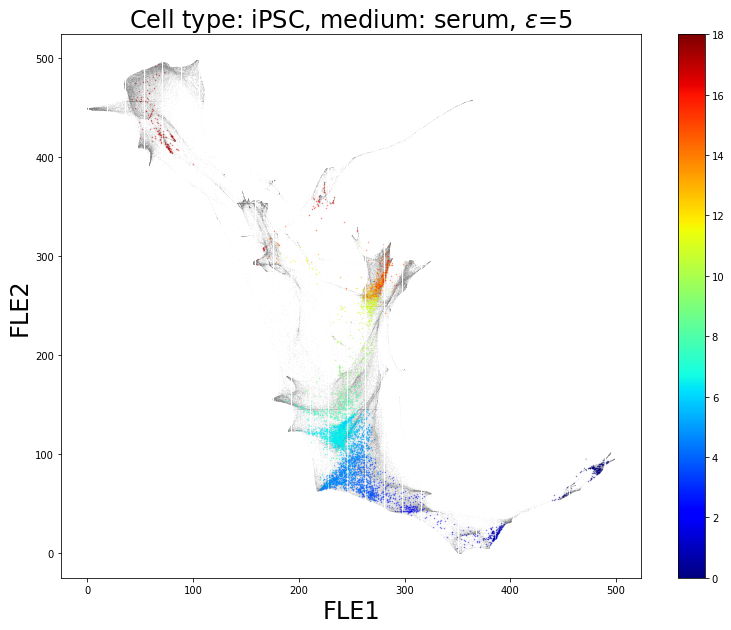

In [38]:
cm = plt.get_cmap('jet')
cNorm  = mpl.colors.Normalize(vmin=0, vmax=len(result))
scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(13, 10))
plt.title(f'Cell type: iPSC, medium: serum, $\epsilon$={5}', fontsize=24)
plt.plot(COORD_DF['x'], COORD_DF['y'], marker='.', color='grey', ls='',
         markersize=0.3, alpha=0.07)
for i in range(len(result)):
    colorVal = scalarMap.to_rgba(i)
    for b in alpha_bins:
        colorVal = np.array(colorVal)
        colorVal[3] = b
        plt.plot(bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "x"],
                 bdata.obs.loc[np.logical_and(bdata.obs["alpha_bin"]==b, bdata.obs["day"]==days[i]), "y"],
               marker='.', color=colorVal, ls='', markersize=1)
plt.xlabel('FLE1', fontsize=24)
plt.ylabel('FLE2', fontsize=24)
ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)
cbar = mpl.colorbar.ColorbarBase(ax, cmap=cm,
                       norm=mpl.colors.Normalize(vmin=0, vmax=18))
plt.show()

In [294]:
bdata.obs

,day,cell_growth_rate,cell_type,alpha_bin
index,,,,
D0_Dox_C1_AAACCTGAGTATCTCG-1,0.0,0.844714,NaN,1.0
D0_Dox_C1_AAACCTGCAAGCGAGT-1,0.0,0.274122,NaN,1.0
D0_Dox_C1_AAACCTGGTCTCTTAT-1,0.0,0.978787,NaN,1.0
D0_Dox_C1_AAACCTGTCAACACTG-1,0.0,0.383064,NaN,1.0
D0_Dox_C1_AAACCTGTCGTTGCCT-1,0.0,0.875599,NaN,1.0
...,...,...,...,...
DiPSC_serum_C2_TTTGTCAGTTCCCGAG-1,NaN,0.434431,Trophoblast,NaN
DiPSC_serum_C2_TTTGTCATCACAGGCC-1,NaN,1.219125,IPS,NaN
DiPSC_serum_C2_TTTGTCATCCTTTACA-1,NaN,2.781941,IPS,NaN


In [295]:
bdata.obb

,day,cell_growth_rate,cell_type,x,y
index,,,,,
D0_Dox_C1_AAACCTGAGTATCTCG-1,0.0,0.844714,NaN,494,101
D0_Dox_C1_AAACCTGCAAGCGAGT-1,0.0,0.274122,NaN,479,85
D0_Dox_C1_AAACCTGGTCTCTTAT-1,0.0,0.978787,NaN,486,91
D0_Dox_C1_AAACCTGTCAACACTG-1,0.0,0.383064,NaN,479,89
D0_Dox_C1_AAACCTGTCGTTGCCT-1,0.0,0.875599,NaN,495,94
...,...,...,...,...,...
DiPSC_serum_C2_TTTGTCAGTTCCCGAG-1,NaN,0.434431,Trophoblast,158,356
DiPSC_serum_C2_TTTGTCATCACAGGCC-1,NaN,1.219125,IPS,50,428
DiPSC_serum_C2_TTTGTCATCCTTTACA-1,NaN,2.781941,IPS,58,414
